## CIFAR 10

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.conv_learner import *
from fastai.models.cifar10.wideresnet import wrn_22_cat, wrn_22, WideResNetConcat
torch.backends.cudnn.benchmark = True
PATH = Path("data/cifar10/")
os.makedirs(PATH,exist_ok=True)

In [3]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))

bs=512
sz=32
workers=7

In [4]:
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
def pad(img, p=4, padding_mode='reflect'):
    return Image.fromarray(np.pad(np.asarray(img), ((p, p), (p, p), (0, 0)), padding_mode))

def torch_loader(data_path, size, prefetcher=True):
    if not os.path.exists(data_path/'train'): download_cifar10(data_path)

    # Data loading code
    traindir = str(data_path/'train')
    valdir = str(data_path/'test')
    tfms = [transforms.ToTensor(), transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))]

    train_tfms = transforms.Compose([
        pad, # TODO: use `padding` rather than assuming 4
        transforms.RandomCrop(size),
        transforms.RandomHorizontalFlip(),
    ] + tfms)

    train_dataset = datasets.ImageFolder(traindir, train_tfms)
    val_dataset = datasets.ImageFolder(valdir, transforms.Compose(tfms))

    train_loader = DataLoader(
        train_dataset, batch_size=bs, shuffle=True,
        num_workers=workers, pin_memory=True)

    val_loader = DataLoader(
        val_dataset, batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)
    
    aug_loader = DataLoader(
        datasets.ImageFolder(valdir, train_tfms),
        batch_size=bs, shuffle=False,
        num_workers=workers, pin_memory=True)

    if prefetcher:
        train_loader = DataPrefetcher(train_loader)
        val_loader = DataPrefetcher(val_loader)
        aug_loader = DataPrefetcher(aug_loader)
    
    data = ModelData(data_path, train_loader, val_loader)
    data.sz = size
    data.aug_dl = aug_loader
    return data

# Seems to speed up training by ~2%
class DataPrefetcher():
    def __init__(self, loader, stop_after=None):
        self.loader = loader
        self.dataset = loader.dataset
        self.stream = torch.cuda.Stream()
        self.stop_after = stop_after
        self.next_input = None
        self.next_target = None

    def __len__(self):
        return len(self.loader)

    def preload(self):
        try:
            self.next_input, self.next_target = next(self.loaditer)
        except StopIteration:
            self.next_input = None
            self.next_target = None
            return
        with torch.cuda.stream(self.stream):
            self.next_input = self.next_input.cuda(async=True)
            self.next_target = self.next_target.cuda(async=True)

    def __iter__(self):
        count = 0
        self.loaditer = iter(self.loader)
        self.preload()
        while self.next_input is not None:
            torch.cuda.current_stream().wait_stream(self.stream)
            input = self.next_input
            target = self.next_target
            self.preload()
            count += 1
            yield input, target
            if type(self.stop_after) is int and (count > self.stop_after):
                break

In [5]:
data = torch_loader(PATH, sz)

In [6]:
'''Pre-activation ResNet in PyTorch.

Reference:
[1] Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun
    Identity Mappings in Deep Residual Networks. arXiv:1603.05027
'''
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable


class AdaptiveConcatPool2d(nn.Module):
    def __init__(self, sz=None):
        super().__init__()
        sz = sz or (1,1)
        self.ap = nn.AdaptiveAvgPool2d(sz)
        self.mp = nn.AdaptiveMaxPool2d(sz)
    def forward(self, x): return torch.cat([self.mp(x), self.ap(x)], 1)
    

class PreActBlock(nn.Module):
    '''Pre-activation version of the BasicBlock.'''
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBlock, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.bn2.bias.data.zero_()
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x), inplace=True)
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out), inplace=True))
        out += shortcut
        return out


class PreActBottleneck(nn.Module):
    '''Pre-activation version of the original Bottleneck module.'''
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(PreActBottleneck, self).__init__()
        self.bn1 = nn.BatchNorm2d(in_planes)
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)

        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False)
            )

    def forward(self, x):
        out = F.relu(self.bn1(x))
        shortcut = self.shortcut(out) if hasattr(self, 'shortcut') else x
        out = self.conv1(out)
        out = self.conv2(F.relu(self.bn2(out)))
        out = self.conv3(F.relu(self.bn3(out)))
        out += shortcut
        return out


class PreActResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10, concatpool=False):
        super(PreActResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.pool = AdaptiveConcatPool2d() if concatpool else nn.AdaptiveMaxPool2d((1,1))
        
        self.linear = nn.Linear(512*block.expansion*(concatpool+1), num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv1(x)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
#         out = F.adaptive_max_pool2d(out, 1)
        out = self.pool(out)
        out = out.view(out.size(0), -1)
        return F.log_softmax(self.linear(out))

def preact_resnet18(): return PreActResNet(PreActBlock, [2,2,2,2])
def preact_resnet2332(): return PreActResNet(PreActBlock, [2,3,3,2])
def preact_resnet3333(): return PreActResNet(PreActBlock, [3,3,3,3])
def preact_resnet34(): return PreActResNet(PreActBlock, [3,4,6,3])
def preact_resnet50(): return PreActResNet(PreActBottleneck, [3,4,6,3])
def preActResNet101(): return PreActResNet(PreActBottleneck, [3,4,23,3])
def preActResNet152(): return PreActResNet(PreActBottleneck, [3,8,36,3])


In [7]:
# m = WideResNetConcat(num_groups=3, N=3, num_classes=10, k=1, drop_p=0.)

In [8]:
def get_TTA_accuracy(learn):
    preds, targs = learn.TTA()
    # combining the predictions across augmented and non augmented inputs
    preds = 0.6 * preds[0] + 0.4 * preds[1:].sum(0)
    return accuracy_np(preds, targs)

def get_TTA_accuracy_2(learn):
    log_preds,y = learn.TTA()
    preds = np.mean(np.exp(log_preds),0)
    acc = accuracy(torch.FloatTensor(preds),torch.LongTensor(y))
    print('TTA acc:', acc)

In [26]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

In [27]:
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512, wd_loss=False)

In [19]:
learn.lr_find()

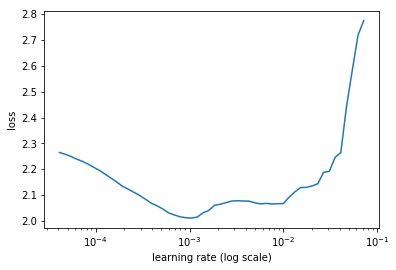

In [20]:
learn.sched.plot()

In [28]:
def_phase = {'opt_fn':optim.Adam, 'wds':wd}
# TODO: add momentum
# %time learn.fit(lr, 1, wds=wd, cycle_len=23, use_clr_beta=(20,22,0.95,0.85), loss_scale=512)
phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-5, 5e-5), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=11, lr=(5e-5,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=13, lr=(1e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.851507   1.593844   0.4134    
    1      1.486369   1.311548   0.5204                   
    2      1.238115   1.198653   0.5726                   
    3      1.039816   1.082675   0.6251                   
    4      0.875044   0.827393   0.7073                    
    5      0.740601   0.83829    0.7182                    
    6      0.63297    0.751212   0.7379                    
    7      0.577767   0.635441   0.7802                    
    8      0.522856   0.585981   0.8039                    
    9      0.477537   0.624951   0.7915                    
    10     0.433186   0.90943    0.7491                    
    11     0.413012   0.464372   0.8429                    
    12     0.38576    0.514638   0.8323                    
    13     0.34266    0.478689   0.8427                    
    14     0.306832   0.573514   0.8255                    
    15     0.267216   0.358149   0.8805                    


[array([0.27785]), 0.9221000005722045]

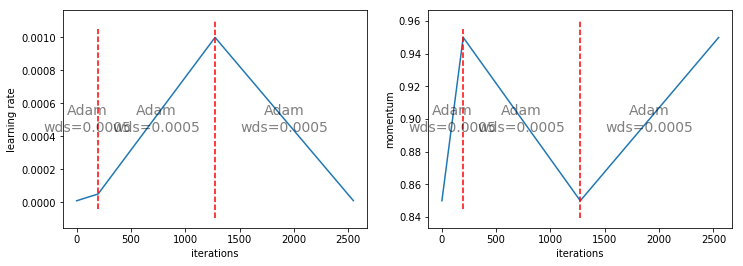

In [30]:
learn.sched.plot_lr()

In [32]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(5e-5, 1e-4), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-4,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-3,1e-4), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=4, lr=(1e-4,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.567317   1.420968   0.4831    
    1      1.24506    1.160416   0.5909                   


[array([1.16042]), 0.5908999997138977]

In [34]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=1e-3
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.372414   1.252441   0.5538    
    1      1.012821   1.251488   0.589                    


[array([1.25149]), 0.5890000005722046]

In [36]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.414275   1.305264   0.5362    
    1      1.022454   1.874044   0.4843                   


[array([1.87404]), 0.48430000047683713]

In [37]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=5e-4
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=4, lr=(1e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.382859   1.367247   0.5276    
    1      1.018324   1.056785   0.6434                   
    2      0.800145   0.748975   0.7465                    
    3      0.716897   0.836286   0.7319                    
    4      0.618429   0.761866   0.7555                    
    5      0.553206   0.746344   0.7765                    
    6      0.501526   0.677209   0.7778                    
    7      0.45216    0.494009   0.832                     
    8      0.415174   0.538943   0.8258                    
    9      0.38564    0.552382   0.8304                    
    10     0.381947   0.473842   0.8434                    
    11     0.370942   0.553348   0.8223                    
    12     0.33347    0.430544   0.8561                    
    13     0.284198   0.456741   0.8519                    
    14     0.237808   0.436026   0.8634                    
    15     0.207499   0.401205   0.8829                   

[array([0.26623]), 0.9352000007629394]

In [38]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=1e-3
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=4, lr=(1e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.364697   1.241795   0.5703    
    1      1.013978   0.983574   0.6675                   
    2      0.816143   1.008537   0.6815                    
    3      0.716124   0.868614   0.7214                    
    4      0.61652    0.729542   0.7678                    
    5      0.560507   0.616775   0.803                     
    6      0.491355   0.605399   0.795                     
    7      0.451826   0.720548   0.7912                    
    8      0.41966    0.55302    0.8178                    
    9      0.396534   0.548765   0.8243                    
    10     0.383961   0.584403   0.8202                    
    11     0.355886   0.569659   0.815                     
    12     0.325505   0.458208   0.856                     
    13     0.286498   0.392464   0.8757                    
    14     0.239493   0.467269   0.8607                    
    15     0.206521   0.392013   0.8834                   

[array([0.27372]), 0.931100000667572]

In [39]:
m = PreActResNet(PreActBlock, [2,2,2,2], concatpool=True)
learn = Learner.from_model_data(m, data)
learn.half()
learn.crit = nn.CrossEntropyLoss()
learn.opt_fn = optim.Adam
learn.metrics = [accuracy]
wd=1e-4
lr=1e-3
learn.clip = 3e-1

def_phase = {'opt_fn':optim.Adam, 'wds':wd}

phases = [
    TrainingPhase(**def_phase, epochs=2, lr=(1e-4, 1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-3,1e-2), lr_decay=DecayType.LINEAR, momentum=(0.95,0.85), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=10, lr=(1e-2,1e-3), lr_decay=DecayType.LINEAR, momentum=(0.85,0.95), momentum_decay=DecayType.LINEAR, wd_loss=False),
    TrainingPhase(**def_phase, epochs=4, lr=(1e-3,1e-5), lr_decay=DecayType.LINEAR, momentum=(0.95,0.98), momentum_decay=DecayType.LINEAR, wd_loss=False)
]

learn.fit_opt_sched(phases, loss_scale=512)

epoch      trn_loss   val_loss   accuracy                 
    0      1.376607   1.41537    0.5122    
    1      1.02033    1.058099   0.6245                   
    2      0.812144   0.965839   0.6796                    
    3      0.689686   1.13771    0.6668                    
    4      0.643241   0.753      0.7452                    
    5      0.56485    0.708794   0.7784                    
    6      0.49328    1.255028   0.6811                    
    7      0.473222   0.642742   0.79                      
    8      0.415324   0.596673   0.8029                    
    9      0.402921   0.50783    0.831                     
    10     0.383827   0.626267   0.8051                    
    11     0.363767   0.435163   0.8557                    
    12     0.321468   0.471006   0.8507                    
    13     0.285442   0.436239   0.8607                    
    14     0.240294   0.353075   0.8883                    
    15     0.210536   0.403833   0.8787                   

[array([0.27847]), 0.9307000003814697]

In [ ]:
learn.load('att6-tta')

In [ ]:
phases = [TrainingPhase(**def_phase, epochs=4, lr=(.04,.001), lr_decay=DecayType.LINEAR, momentum=(0.95))]
learn.fit_opt_sched(phases, data_list=[data], loss_scale=512)

In [ ]:
tta_data = torch_loader(PATH, sz, prefetcher=False)

In [ ]:
learn.data_ = tta_data

In [ ]:
get_TTA_accuracy(learn)

In [ ]:
get_TTA_accuracy_2(learn)